# Tier 2: Macro View - Mapping the Structure
This notebook analyzes the network structure of the research field. The goal is to understand how entities are connected, how ideas flow through the network, and where structural gaps and research opportunities might exist.

In [68]:
import pandas as pd
from neo4j import GraphDatabase
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from adjustText import adjust_text
import community as community_louvain

# --- Connect to Neo4j ---
load_dotenv()
URI = os.getenv("NEO4J_URI")
AUTH = (os.getenv("NEO4J_USERNAME"), os.getenv("NEO4J_PASSWORD"))
driver = GraphDatabase.driver(URI, auth=AUTH)

# --- Helper Function to run queries and return a DataFrame ---
def query_to_dataframe(driver, query, **params):
    """
    This function executes a Cypher query against the database
    and returns the results as a pandas DataFrame.
    """
    with driver.session() as session:
        result = session.run(query, **params)
        return pd.DataFrame([r.data() for r in result])

print("Setup complete. Connected to Neo4j.")

Setup complete. Connected to Neo4j.


In [71]:
def plot_network(G, title, labels_to_draw=None, node_size_attr=None, node_color_attr=None):
    """
    Creates and displays a styled, publication-quality network graph.
    
    Args:
        G (nx.Graph): The NetworkX graph object to plot.
        title (str): The title of the plot.
        labels_to_draw (dict): A dictionary of {node: label} for nodes to be labeled.
        node_size_attr (str): The node attribute to use for sizing.
        node_color_attr (str): The node attribute to use for coloring.
    """
    fig, ax = plt.subplots(figsize=(20, 20))
    pos = nx.spring_layout(G, k=0.3, iterations=50, seed=42)

    # --- Node Sizing ---
    if node_size_attr and nx.get_node_attributes(G, node_size_attr):
        sizes = [val * 50 for val in nx.get_node_attributes(G, node_size_attr).values()]
    else:
        sizes = 200 # Default size

    # --- Node Coloring ---
    colors = 'skyblue'
    cmap = None
    if node_color_attr and nx.get_node_attributes(G, node_color_attr):
        color_values = list(nx.get_node_attributes(G, node_color_attr).values())
        
        # It checks if the attribute is categorical (strings) or numerical.
        if all(isinstance(v, str) for v in color_values):
            # Categorical: It maps strings to numbers.
            unique_categories = sorted(list(set(color_values)))
            category_map = {cat: i for i, cat in enumerate(unique_categories)}
            colors = [category_map[val] for val in nx.get_node_attributes(G, node_color_attr).values()]
            cmap = plt.cm.jet
        else:
            # Numerical: It uses the values directly.
            colors = color_values
            cmap = plt.cm.plasma

    # --- Drawing ---
    nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=colors, cmap=cmap, alpha=0.8)
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.6)
    
    # --- Labeling ---
    if labels_to_draw:
        texts = [plt.text(pos[node][0], pos[node][1], label, fontsize=12, ha='right', va='center') 
                 for node, label in labels_to_draw.items() if node in pos]
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))

    ax.set_title(title, fontsize=20)
    plt.show()

## 1. How are researchers collaborating?
This section explores the social structure of the research community through co-authorship analysis.

### Pre Computation and Data Fetching

In [61]:
# --- Pre-computation Query: Create CO_AUTHOR relationships ---
create_coauthor_rels_query = """
MATCH (a1:Author)-[:AUTHORED]->(p:Paper)<-[:AUTHORED]-(a2:Author)
WHERE elementId(a1) < elementId(a2)
MERGE (a1)-[r:CO_AUTHOR]-(a2)
ON CREATE SET r.collaborations = 1
ON MATCH SET r.collaborations = r.collaborations + 1
"""
print("Materializing CO_AUTHOR relationships...")
with driver.session() as session:
    session.run(create_coauthor_rels_query)
print("CO_AUTHOR relationships created/updated.")

# --- Fetch co-author data for visualization ---
coauthor_graph_query = """
MATCH (a1:Author)-[r:CO_AUTHOR]-(a2:Author)
RETURN a1.name AS source, a2.name AS target, r.collaborations AS weight
"""
coauthor_df = query_to_dataframe(driver, coauthor_graph_query)
print(f"Fetched {len(coauthor_df)} co-authorship links.")

# --- Fetch data for top 15 hub authors ---
hub_authors_query = """
MATCH (a:Author)
RETURN a.name AS author, COUNT { (a)-[:CO_AUTHOR]-() } AS collaborators
ORDER BY collaborators DESC
LIMIT 15
"""
hub_authors_df = query_to_dataframe(driver, hub_authors_query)

Materializing CO_AUTHOR relationships...
CO_AUTHOR relationships created/updated.
Fetched 31514 co-authorship links.


### 1.1 Visualization of Co-Authorship Network
This cell addresses your feedback on the graph visualization. It now correctly performs community detection and generates two plots: a high-level "Macro" view of the communities and a detailed "Micro" view of the largest community with non-overlapping labels for the key authors.

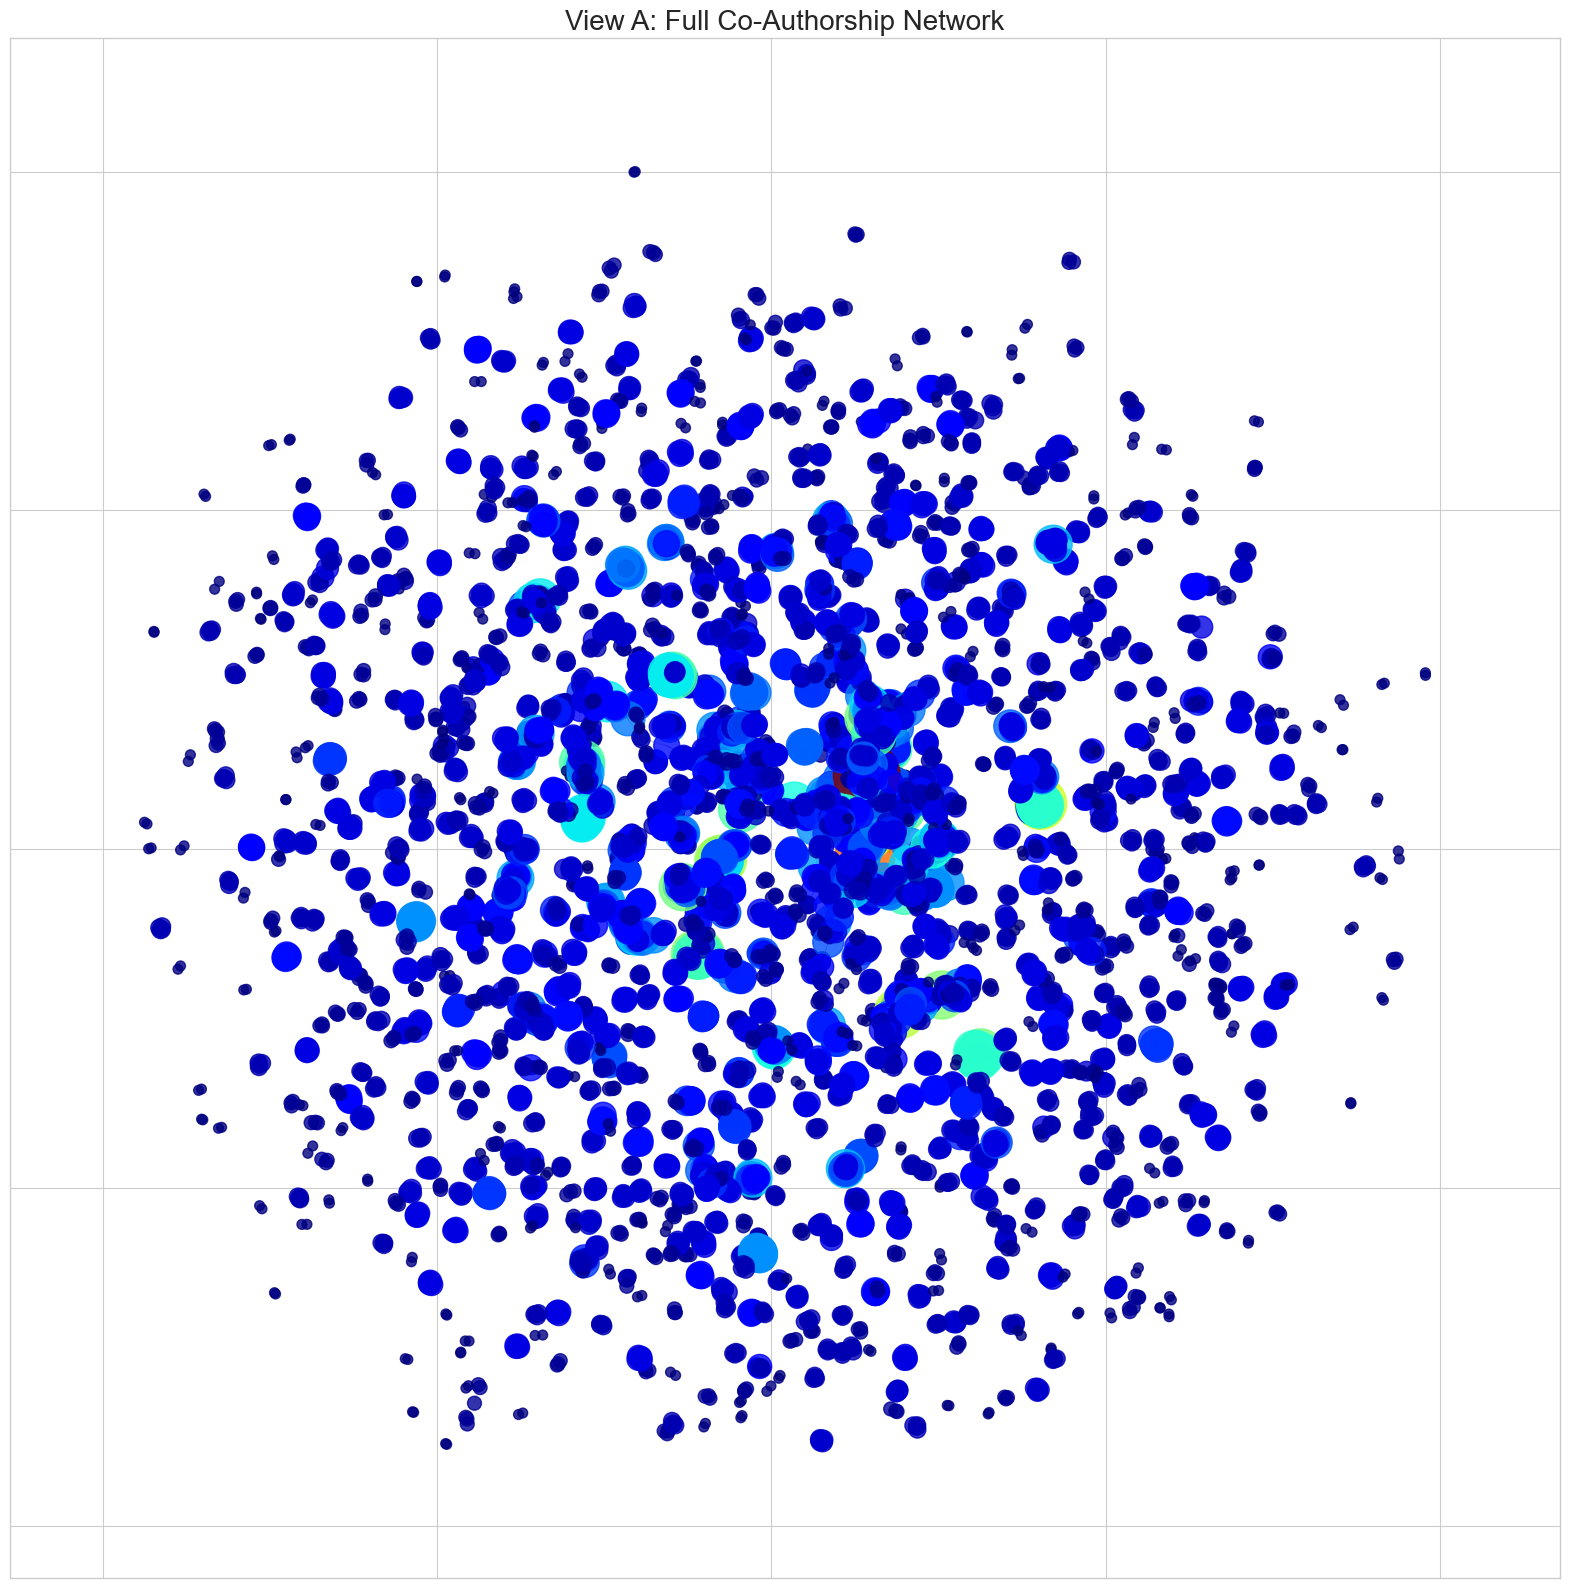

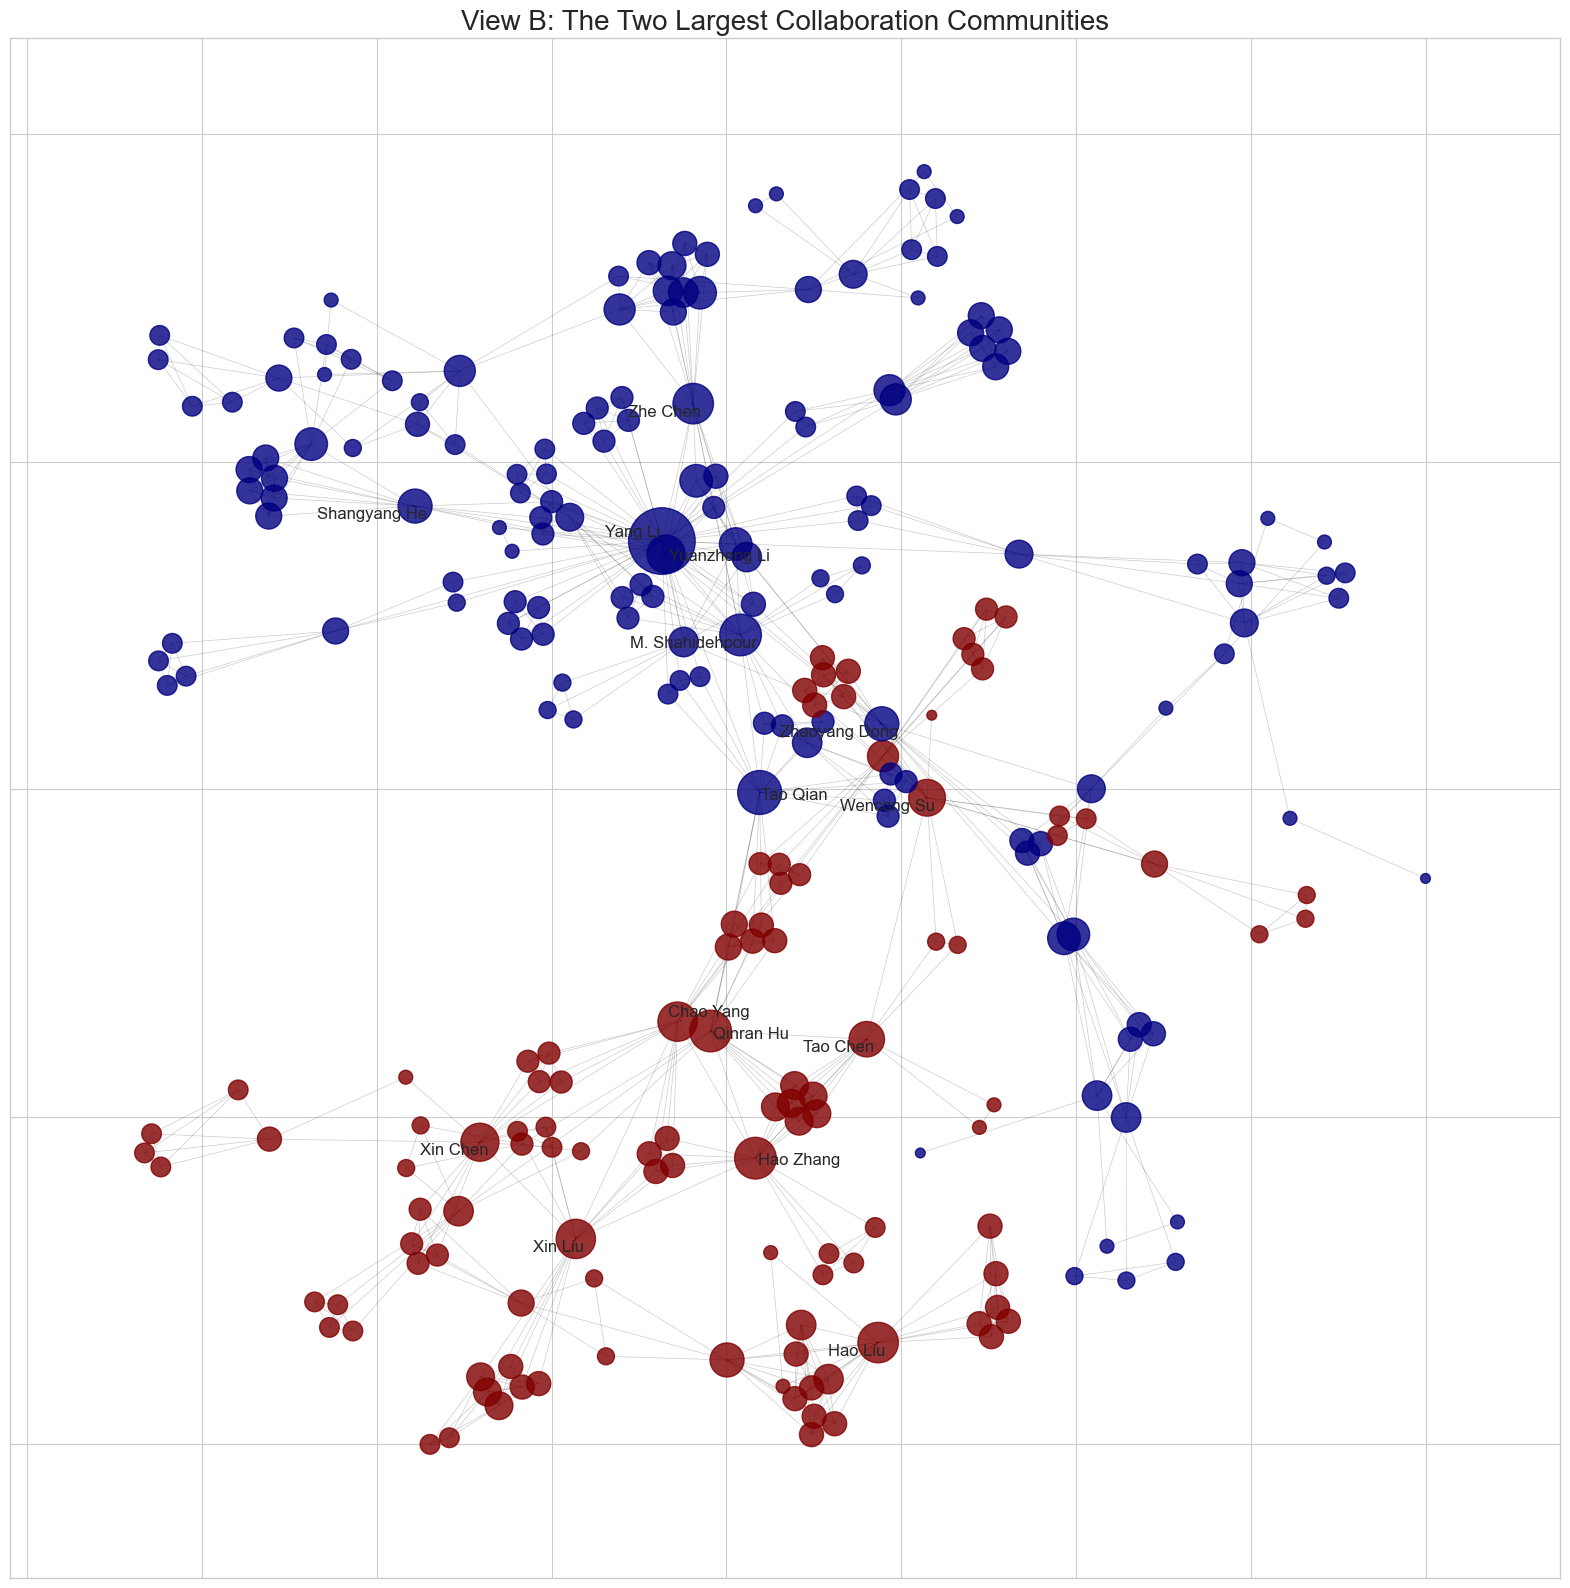

In [66]:
# --- 1. Prepare the graph data ---
G = nx.from_pandas_edgelist(coauthor_df, 'source', 'target', edge_attr='weight')

# Calculate degree and add it as a node attribute for sizing
degrees = dict(G.degree())
nx.set_node_attributes(G, degrees, 'degree')

# Perform community detection and add it as a node attribute for coloring
partition = community_louvain.best_partition(G)
nx.set_node_attributes(G, partition, 'community')

# --- 2. Generate View A: Board View of the Entire Network ---
# This view shows the full network, with nodes sized and colored by their number of connections.
plot_network(G, 
             title='View A: Full Co-Authorship Network',
             node_size_attr='degree',
             node_color_attr='degree')


# --- 3. Generate View B: Zoomed-in View of the Two Largest Communities ---
# It identifies the two largest communities.
community_counts = pd.Series(partition).value_counts()
top_two_communities = community_counts.nlargest(2).index.tolist()
top_two_nodes = [node for node, comm_id in partition.items() if comm_id in top_two_communities]
subgraph = G.subgraph(top_two_nodes)

# It identifies the top authors within this subgraph for labeling.
top_authors_in_subgraph = sorted(dict(subgraph.degree()), key=dict(subgraph.degree()).get, reverse=True)[:15]
labels_to_draw = {author: author for author in top_authors_in_subgraph}

# It calls the same plotting function for a consistent style.
plot_network(subgraph, 
             title='View B: The Two Largest Collaboration Communities',
             node_size_attr='degree',
             node_color_attr='community',
             labels_to_draw=labels_to_draw)

### 1.2 Bridge Author Analysis
This analysis seeks to find authors who connect different disciplines by identifying those who have published papers in both 'Computer Science' and 'Engineering'.

/Users/stahlma/.pyenv/versions/causal-rl-ev/lib/python3.11/site-packages/adjustText/__init__.py:419: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  ax.figure.draw_without_rendering()
/Users/stahlma/.pyenv/versions/causal-rl-ev/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


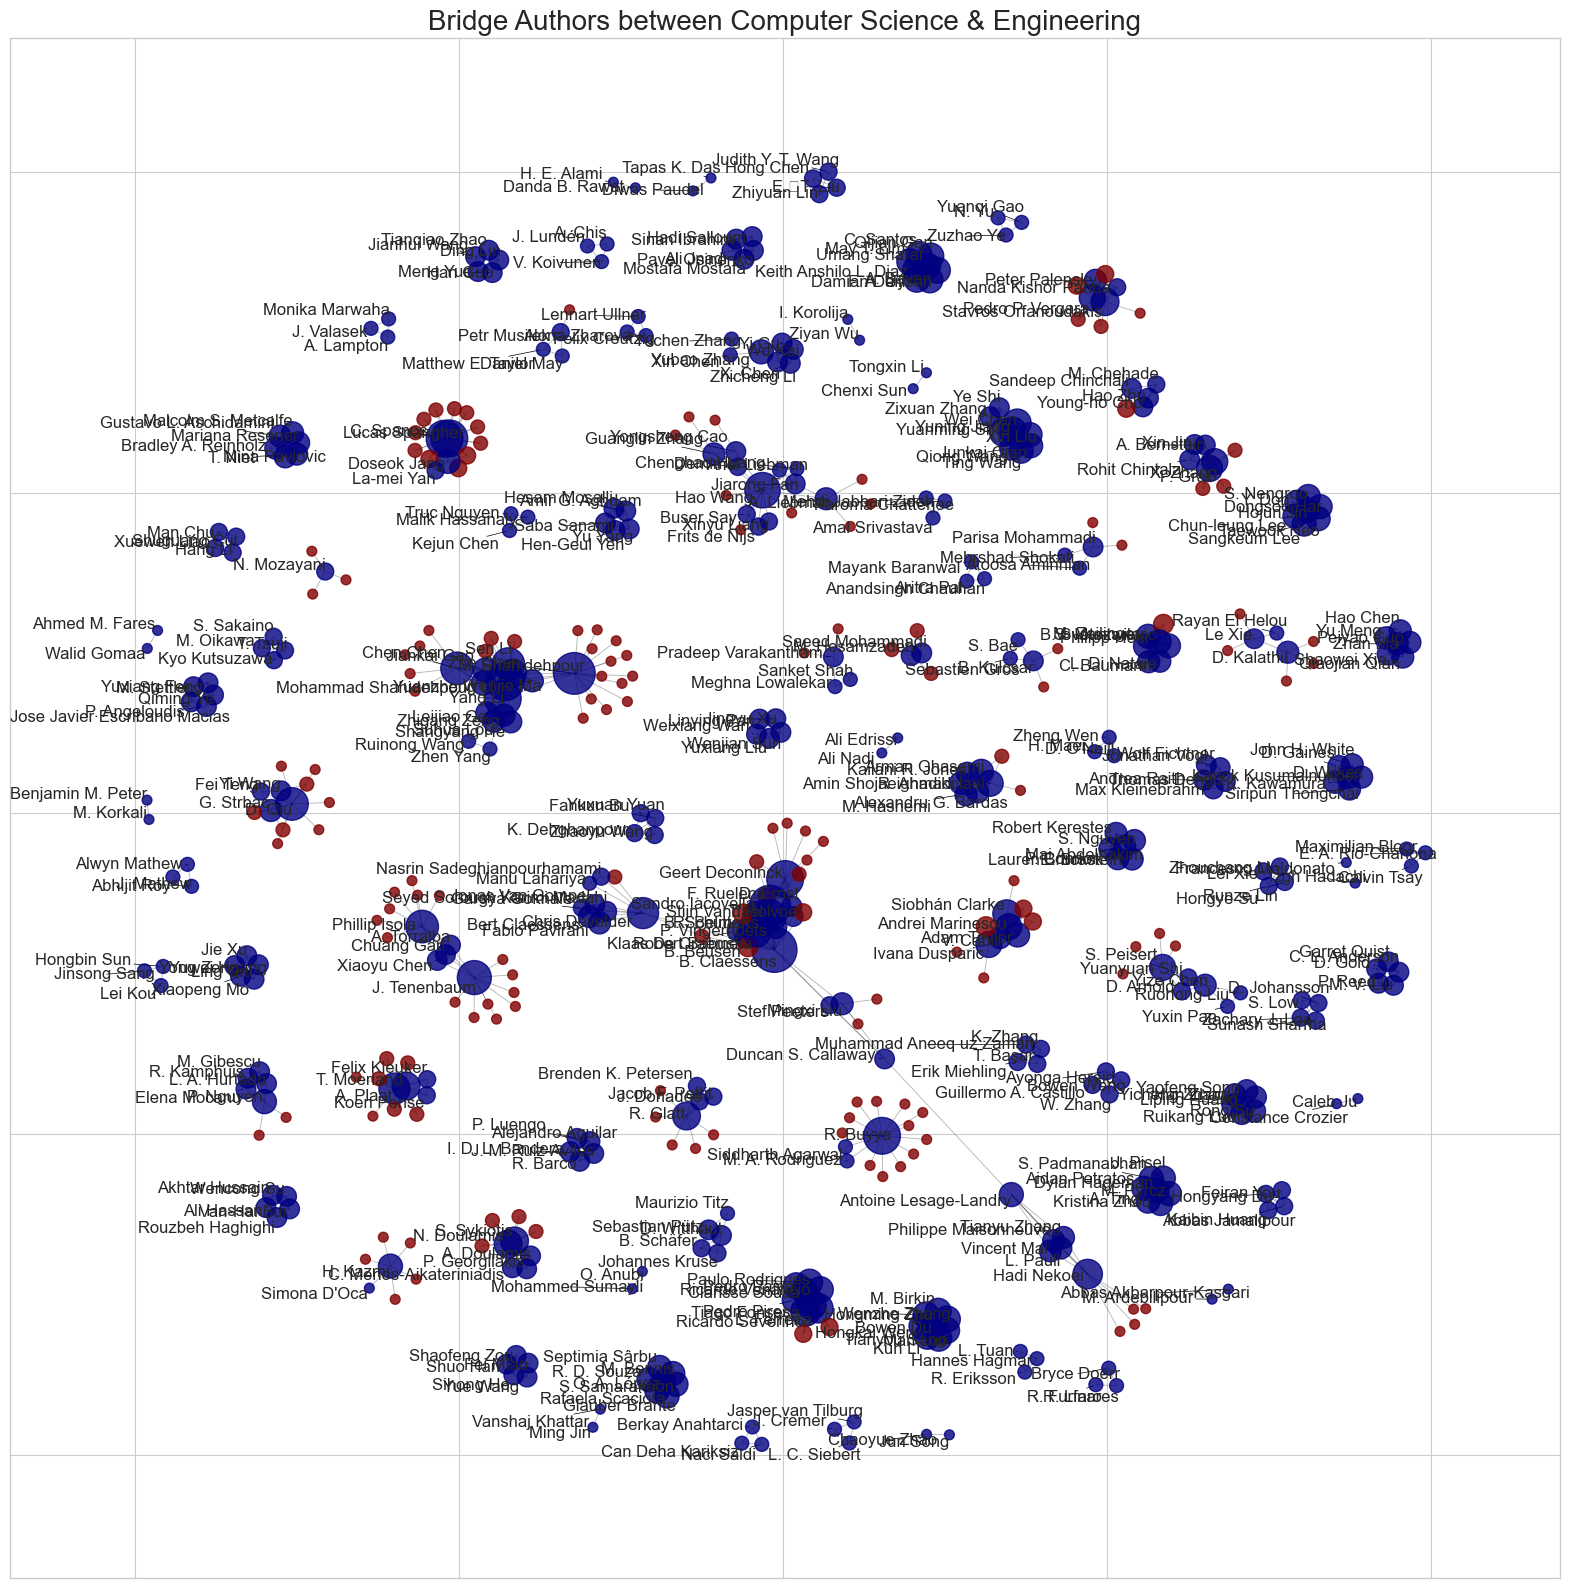

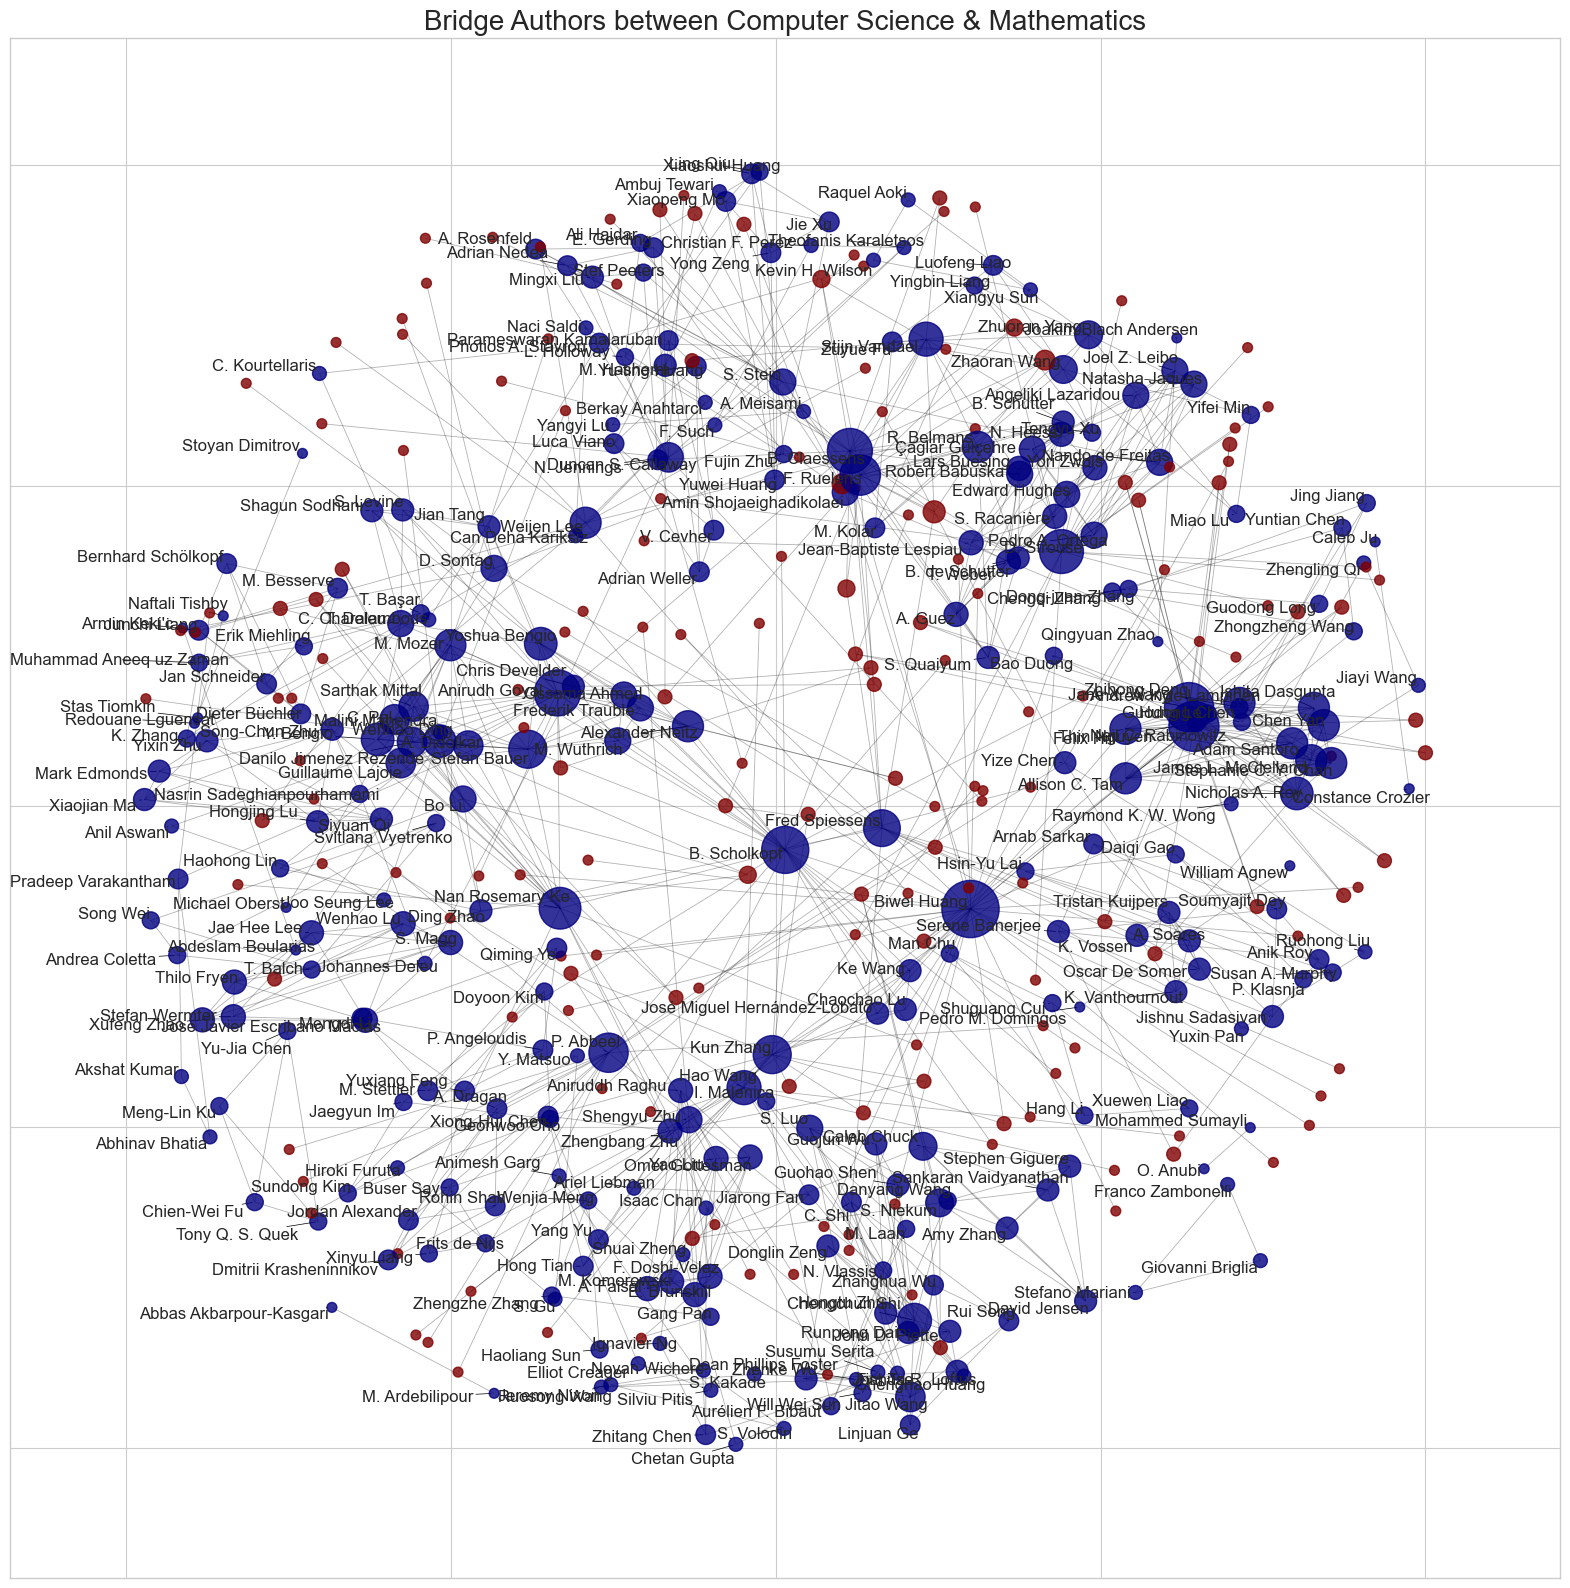

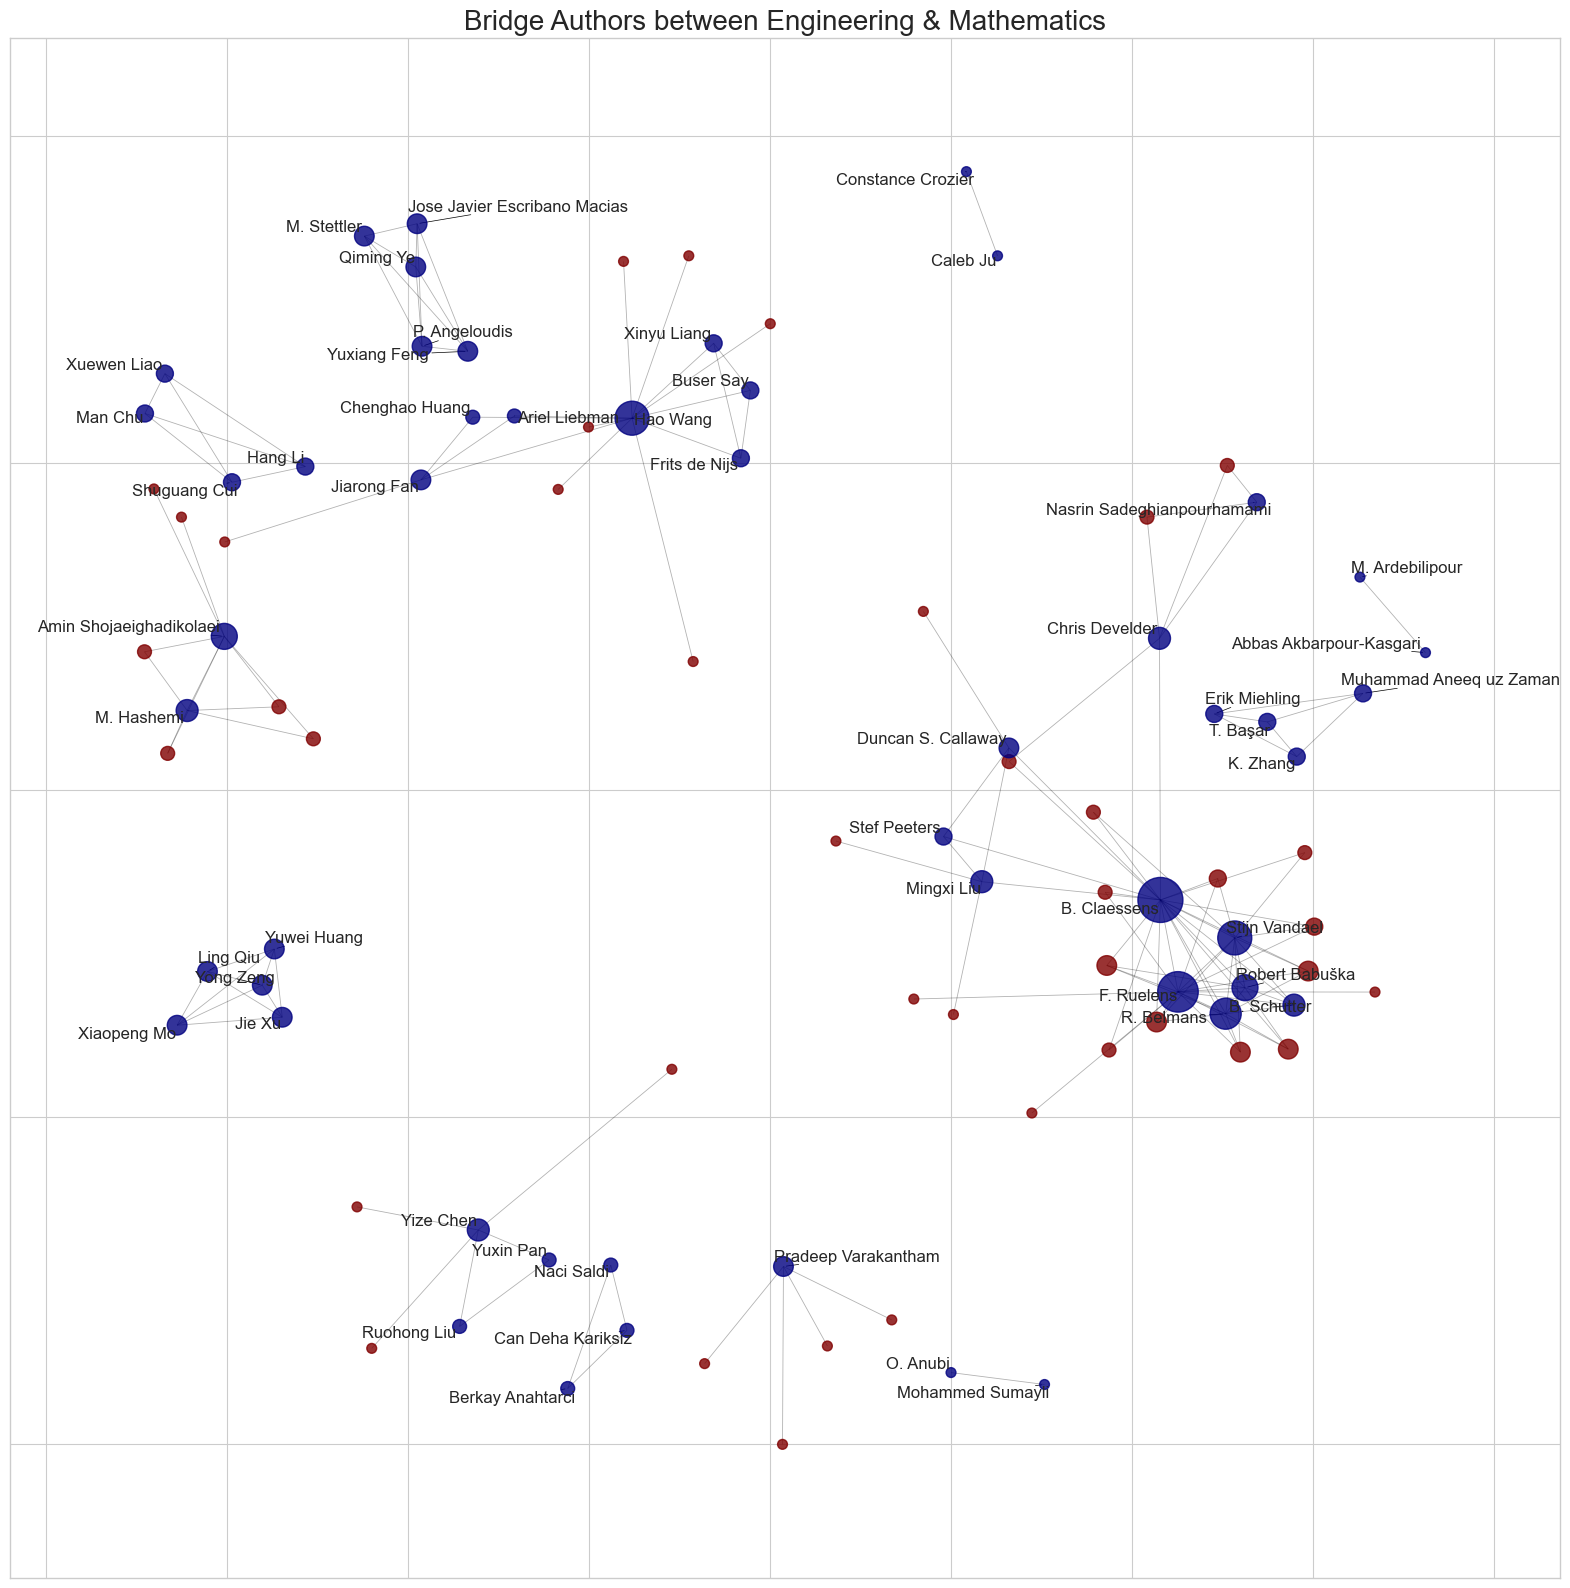

In [72]:
def visualize_bridge_authors(field1, field2):
    """
    Queries and visualizes the collaboration network of authors who bridge two fields of study.
    """
    bridge_graph_query = f"""
    MATCH (a:Author)-[:AUTHORED]->(:Paper)-[:HAS_FIELD]->(:FieldOfStudy {{name: "{field1}"}})
    MATCH (a)-[:AUTHORED]->(:Paper)-[:HAS_FIELD]->(:FieldOfStudy {{name: "{field2}"}})
    WITH a
    MATCH (a)-[r:CO_AUTHOR]-(co_author:Author)
    RETURN a.name as bridge_author, co_author.name as collaborator
    """
    bridge_df = query_to_dataframe(driver, bridge_graph_query)

    if bridge_df.empty:
        print(f"No bridge author collaborations found to visualize between {field1} and {field2}.")
        return

    bridge_graph = nx.from_pandas_edgelist(bridge_df, 'bridge_author', 'collaborator')
    
    # Add attributes for styling
    bridge_authors = set(bridge_df['bridge_author'])
    node_types = {node: 'bridge' if node in bridge_authors else 'collaborator' for node in bridge_graph.nodes()}
    nx.set_node_attributes(bridge_graph, node_types, 'type')
    
    degrees = dict(bridge_graph.degree())
    nx.set_node_attributes(bridge_graph, degrees, 'degree')
    
    labels_to_draw = {node: node for node in bridge_authors}

    # Call the master plotting function
    plot_network(bridge_graph, 
                 title=f'Bridge Authors between {field1} & {field2}',
                 node_size_attr='degree',
                 node_color_attr='type', # This will color bridge authors differently
                 labels_to_draw=labels_to_draw)


visualize_bridge_authors("Computer Science", "Engineering")
visualize_bridge_authors("Computer Science", "Mathematics")
visualize_bridge_authors("Engineering", "Mathematics")

## 2. How do ideas evolve and spread?
This section analyzes the intellectual structure of the field by examining citation patterns.

### 2.1 Tracing an Intellectual Lineage
This query finds the shortest citation path between an older, foundational paper on demand response and the highly influential "Decision Transformer" paper, showing a potential path of influence.

In [64]:
# --- Query to find the shortest citation path between two key papers (Corrected) ---
lineage_query = """
// Find the top 15 most cited papers overall
MATCH (p_overall:Paper)
WITH p_overall ORDER BY p_overall.citation_count DESC LIMIT 15
WITH collect(p_overall) as top_overall_papers

// Find the top 15 most cited papers in-corpus
MATCH (p_internal)<-[:CITES]-(citer)
WITH top_overall_papers, p_internal, count(citer) as internal_citations
ORDER BY internal_citations DESC LIMIT 15
WITH top_overall_papers, collect(p_internal) as top_internal_papers

// Find the shortest citation paths between the two sets
UNWIND top_overall_papers AS start_node_foundational
UNWIND top_internal_papers AS end_node_domain_specific
WITH start_node_foundational, end_node_domain_specific
WHERE start_node_foundational <> end_node_domain_specific

// --- THIS IS THE FIX ---
// The path search now goes from the domain-specific paper BACK to the foundational one
MATCH path = shortestPath((end_node_domain_specific)-[:CITES*..10]->(start_node_foundational))
// --- END OF FIX ---

RETURN [node in nodes(path) | node.title] AS papers_in_path, length(path) as path_length
ORDER BY path_length
LIMIT 10
"""

print("Tracing citation paths between top overall papers and top in-corpus papers...")
lineage_df = query_to_dataframe(driver, lineage_query)

if not lineage_df.empty:
    print("Found the following citation path(s):")
    for path_list in lineage_df['papers_in_path']:
        print(" -> ".join(path_list))
else:
    print("\nNo direct citation paths were found in the corpus between the two sets of top papers.")
    print("This remains a significant finding, suggesting a disconnect between what is generally influential and what is foundational to this specific domain.")

Tracing citation paths between top overall papers and top in-corpus papers...
Found the following citation path(s):
Definition and Evaluation of Model-Free Coordination of Electrical Vehicle Charging With Reinforcement Learning -> Reinforcement learning for demand response: A review of algorithms and modeling techniques
Reinforcement Learning Based EV Charging Management Systems–A Review -> Model-Free Real-Time EV Charging Scheduling Based on Deep Reinforcement Learning
Reinforcement Learning Based EV Charging Management Systems–A Review -> Definition and Evaluation of Model-Free Coordination of Electrical Vehicle Charging With Reinforcement Learning -> Reinforcement learning for demand response: A review of algorithms and modeling techniques
Reinforcement Learning Based EV Charging Management Systems–A Review -> Reinforcement Learning-Based Energy Management of Smart Home with Rooftop Solar Photovoltaic System, Energy Storage System, and Home Appliances -> Demand Response for Home Ene

### 2.2 Citation Flow and Field Breakdown
This section investigates the flow of ideas between different research topics and the disciplinary makeup of those topics. As discovered previously, the analysis of citation flow between different queries is invalid with the current data model. The data model only links a paper to the first query that discovered it.

Therefore, this analysis will be replaced with a more valid and insightful query: a disciplinary breakdown for each of our key search topics.




Calculating cross-query citation matrix...


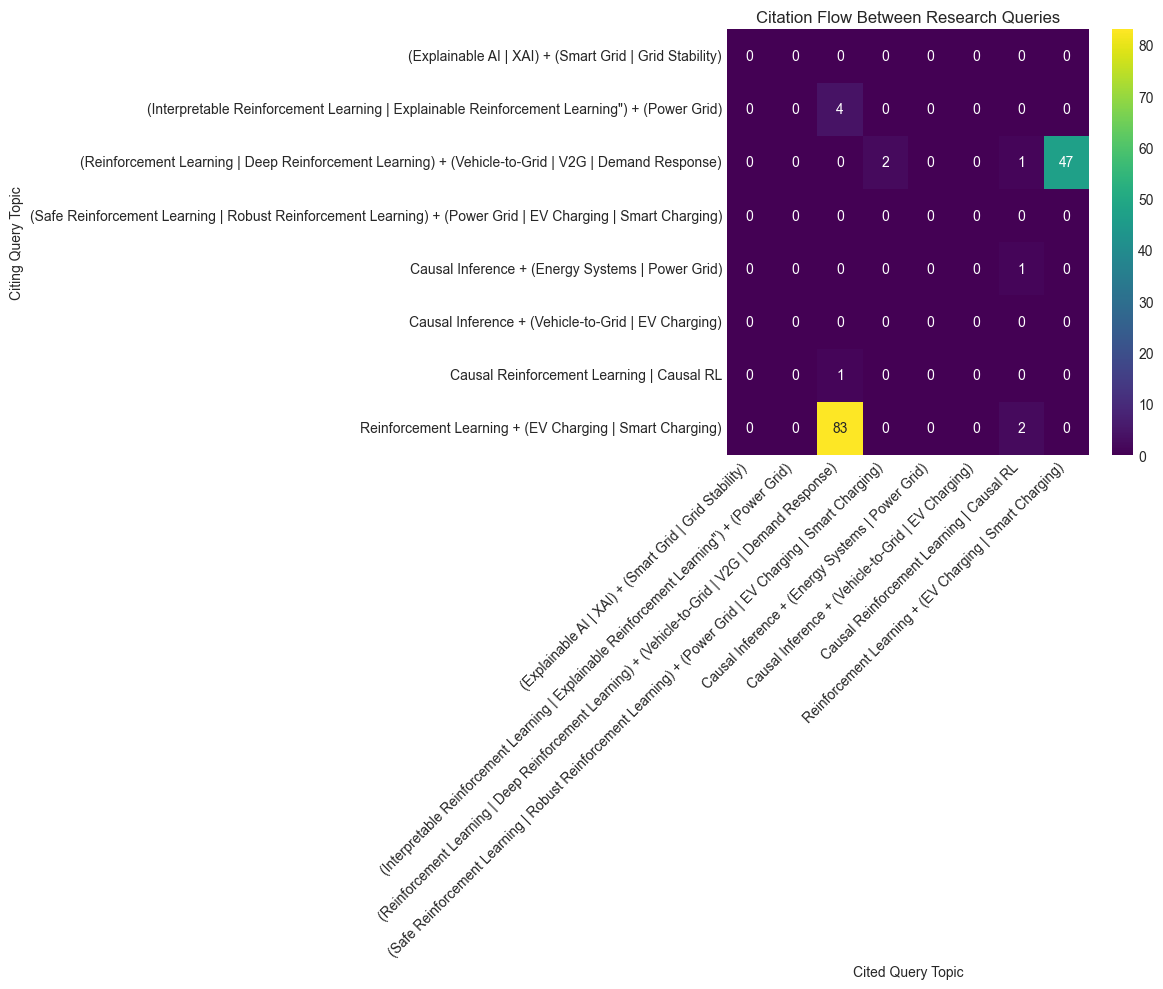

In [53]:
# First, run the Cypher query to get the raw data
cross_query_citations_query = """
MATCH (p1:Paper)-[:FOUND_BY]->(q1:Query)
MATCH (p1)-[:CITES]->(p2:Paper)
MATCH (p2)-[:FOUND_BY]->(q2:Query)
WHERE q1 <> q2
RETURN q1.name AS citing_query, q2.name AS cited_query, count(*) AS number_of_citations
"""
print("\nCalculating cross-query citation matrix...")
cross_query_df = query_to_dataframe(driver, cross_query_citations_query)

# Now, use pandas and seaborn to create the heatmap
# (This code replaces the previous heatmap block)
if not cross_query_df.empty:
    # Get a list of ALL query names to build a complete matrix
    all_queries = query_to_dataframe(driver, "MATCH (q:Query) RETURN q.name AS query")['query'].tolist()
    
    # Create the pivot table
    heatmap_data = cross_query_df.pivot_table(index='citing_query', columns='cited_query', values='number_of_citations')
    
    # --- Improvement: Ensure all queries are in the index and columns ---
    heatmap_data = heatmap_data.reindex(index=all_queries, columns=all_queries).fillna(0)
    
    # Plot the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="viridis")
    plt.title('Citation Flow Between Research Queries')
    plt.xlabel('Cited Query Topic')
    plt.ylabel('Citing Query Topic')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("No cross-query citations found.")


Analyzing the disciplinary breakdown for the 'Causal RL' query...


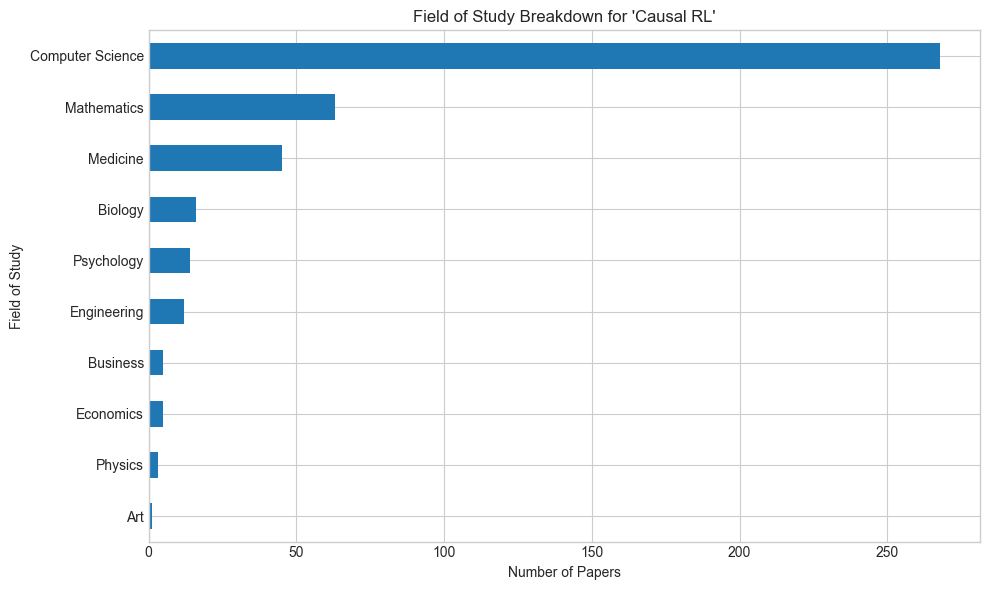


Analyzing the disciplinary breakdown for the 'RL for EV Charging' query...


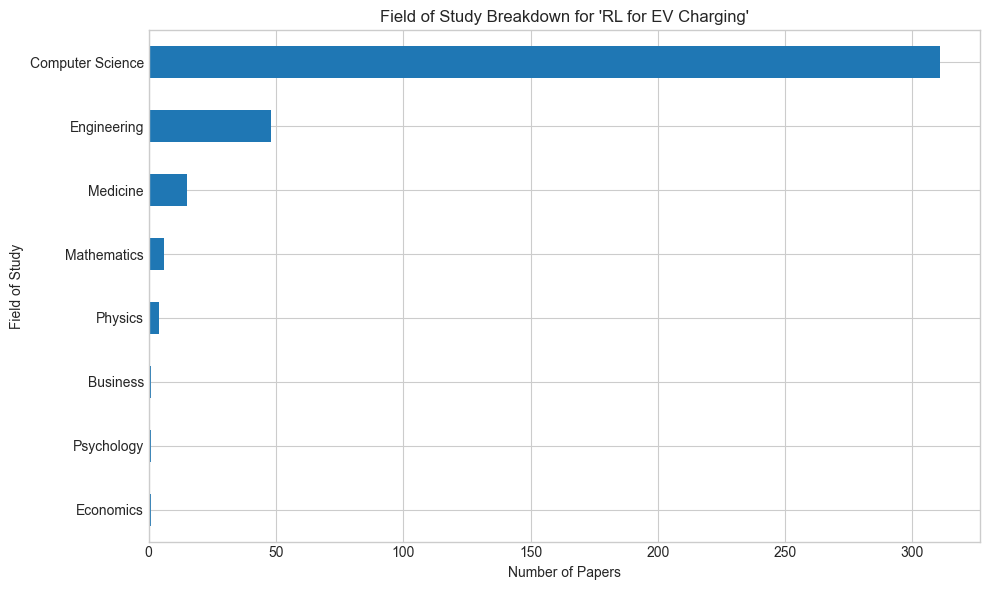


Analyzing the disciplinary breakdown for the 'XAI for Smart Grid' query...


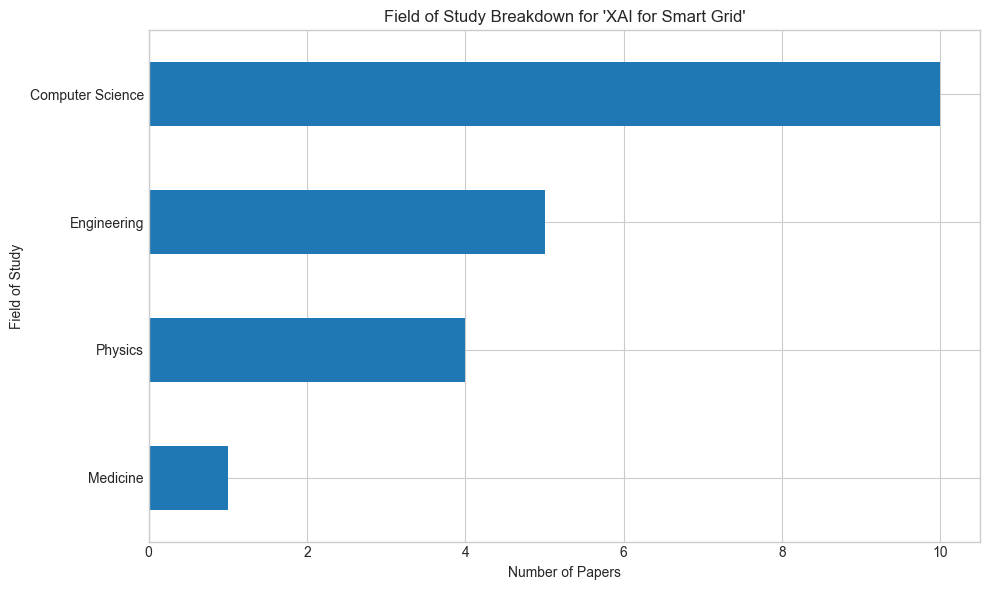

In [54]:
def plot_fos_breakdown_for_query(query_id, query_name):
    """
    Queries and plots the field of study breakdown for a given query ID.
    """
    fos_breakdown_query = f"""
    MATCH (q:Query {{queryId: '{query_id}'}})<-[:FOUND_BY]-(p:Paper)-[:HAS_FIELD]->(f:FieldOfStudy)
    RETURN f.name AS field_of_study, count(p) AS paper_count
    ORDER BY paper_count DESC
    LIMIT 10
    """
    print(f"\nAnalyzing the disciplinary breakdown for the '{query_name}' query...")
    fos_breakdown_df = query_to_dataframe(driver, fos_breakdown_query)

    if fos_breakdown_df.empty:
        print(f"No field of study data found for query: {query_name}")
        return

    # Plotting the results
    fig, ax = plt.subplots(figsize=(10, 6))
    fos_breakdown_df.plot(kind='barh', x='field_of_study', y='paper_count', ax=ax, legend=False)
    ax.set_title(f"Field of Study Breakdown for '{query_name}'")
    ax.set_xlabel('Number of Papers')
    ax.set_ylabel('Field of Study')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

# --- Now, call the function for our key queries ---
plot_fos_breakdown_for_query('Q:causal-reinforcement-learning-causal-rl', "Causal RL")
plot_fos_breakdown_for_query('Q:reinforcement-learning-ev-charging-smart-charging', "RL for EV Charging")
plot_fos_breakdown_for_query('Q:explainable-ai-xai-smart-grid-grid-stability', "XAI for Smart Grid")